              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1213
           1       0.94      0.17      0.29       287

    accuracy                           0.84      1500
   macro avg       0.89      0.59      0.60      1500
weighted avg       0.86      0.84      0.79      1500



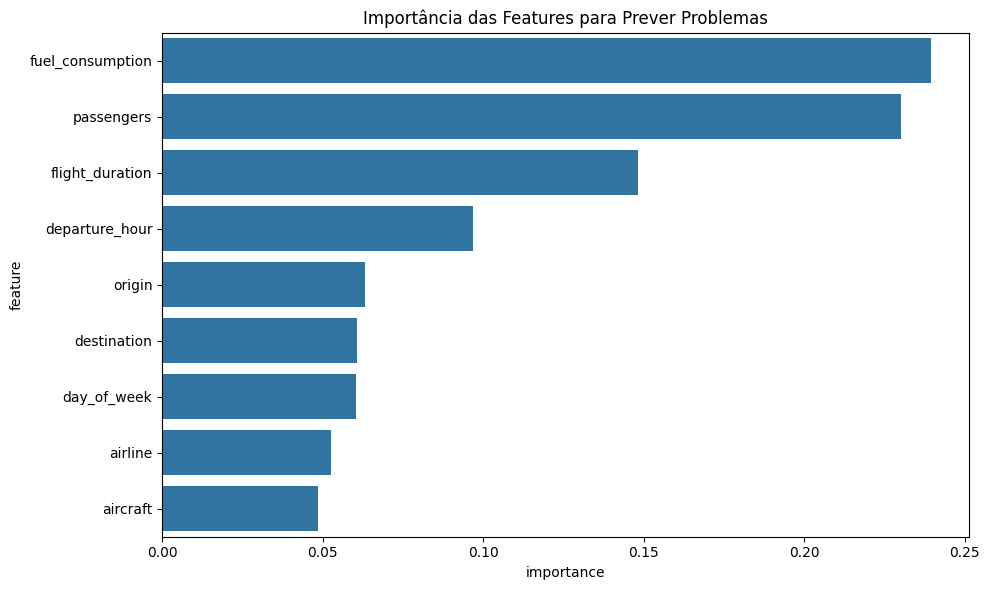

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados validados
flights = pd.read_csv('data/processed/validated_flights.csv', 
                     parse_dates=['departure_time', 'scheduled_arrival', 'actual_arrival'])

# Preparar dados para ML
flights['is_problem'] = (flights['status'] != 'on_time').astype(int)
flights['departure_hour'] = flights['departure_time'].dt.hour
flights['day_of_week'] = flights['departure_time'].dt.dayofweek

# Codificar variáveis categóricas
label_encoders = {}
for col in ['airline', 'origin', 'destination', 'aircraft']:
    le = LabelEncoder()
    flights[col] = le.fit_transform(flights[col])
    label_encoders[col] = le

# Selecionar features
features = ['airline', 'origin', 'destination', 'aircraft', 'flight_duration', 
            'departure_hour', 'day_of_week', 'passengers', 'fuel_consumption']
X = flights[features]
y = flights['is_problem']

# 1. Modelo de Detecção de Anomalias
iso_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
flights['anomaly_score'] = iso_forest.fit_predict(X)
flights['is_anomaly'] = np.where(flights['anomaly_score'] == -1, 1, 0)

# 2. Modelo Preditivo (Problemas em Voos) - Usando RandomForest em vez de XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliar modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features para Prever Problemas')
plt.tight_layout()

# Garantir que o diretório existe
import os
os.makedirs('data/reports', exist_ok=True)

plt.savefig('data/reports/feature_importance.png')
plt.show()

# Salvar resultados
flights.to_csv('data/processed/flights_with_predictions.csv', index=False)